In [19]:
##########################################################################
#                   2D MONTE CARLO NEUTRON TRANSPORT CODE                #
##########################################################################

import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell
np.random.seed()

def CrossSections(Energy,region):

    #===================================================================#
    #         Energy Dependent Macroscopic Cross Section Data           #
    #===================================================================#
    #Unit is 1/cm
    #sigma_x[EnergyGroup][Region]

    sigma_f=np.array([[1.05e-1,0,0],
                      [5.96e-2,0,0],
                      [6.02e-2,0,0],
                      [1.06e-1,0,0],
                      [2.46e-1,0,0],
                      [2.50e-1,0,0],
                      [1.07e-1,0,0],
                      [1.28e+0,0,0],
                      [9.30e+0,0,0],
                      [2.58e+1,0,0]])
    sigma_c=np.array([[1.41e-6,1.71e-2,3.34e-6],
                      [1.34e-3,7.83e-3,3.34e-6],
                      [1.10e-2,2.83e-4,2.56e-7],
                      [3.29e-2,4.52e-6,6.63e-7],
                      [8.23e-2,1.06e-5,2.24e-7],
                      [4.28e-2,4.39e-6,1.27e-7],
                      [9.90e-2,1.25e-5,2.02e-7],
                      [2.51e-1,3.98e-5,6.02e-7],
                      [2.12e+0,1.26e-4,1.84e-6],
                      [4.30e+0,3.95e-4,5.76e-6]])
    sigma_s=np.array([[2.76e-1,1.44e-1,1.27e-2],
                      [3.88e-1,1.76e-1,7.36e-2],
                      [4.77e-1,3.44e-1,2.65e-1],
                      [6.88e-1,2.66e-1,5.72e-1],
                      [9.38e-1,2.06e-1,6.69e-1],
                      [1.52e+0,2.14e-1,6.81e-1],
                      [2.30e+0,2.23e-1,6.82e-1],
                      [2.45e+0,2.31e-1,6.83e-1],
                      [9.79e+0,2.40e-1,6.86e-1],
                      [4.36e+1,2.41e-1,6.91e-1]])
    sigma_t=sigma_f+sigma_c+sigma_s 
    
    #===================================================================#
    #                          Energy Group                             #
    #===================================================================#
    #Unit is MeV
    Group_Energy=[3e+1,    #Group0
                  3e+0,    #Group1
                  3e-1,    #Group2
                  3e-2,    #Group3
                  3e-3,    #Group4
                  3e-4,    #Group5
                  3e-5,    #Group6
                  3e-6,    #Group7
                  3e-7,    #Group8
                  3e-8]    #Group9 
    for g in range(len(Group_Energy)):
        if Energy>=Group_Energy[g]:
            #Neutron in Group g
            group=g
            break
    #print(group,Energy)

    #===================================================================#
    #                        Cross Sections                             #
    #===================================================================#
    #Unit is 1/cm
    
    sig_f=sigma_f[group][region]
    sig_c=sigma_c[group][region]
    sig_s=sigma_s[group][region]
    sig_t=sigma_t[group][region]
    sig=[sig_f,sig_c,sig_s,sig_t]
    
    return sig

def Qualifying2D(Neutrons_Number):

    #===================================================================#
    #                         Initialization                            #
    #===================================================================#

    print("Number of Neutrons.......................= ",Neutrons_Number)  # Number of initial neutrons
    Neutrons_Produced=0                                 # Number of fission neutrons
    interaction_point_x=[]                              # list for x coordinate of interaction point
    interaction_point_y=[]                              # list for y coordinate of interaction point
    Fission=0                                           # Number of fission interactions
    nu=0
    Capture=0                                           # Number of absorption interactions
    Absorption=0                                        # Number of absorption interactions
    Scattering=0                                        # Number of scattering interactions
    Leakage=0                                           # Number of leaked neutrons

    #===================================================================#
    #                            Geometry                               #
    #===================================================================#

    r_fuel     = 0.53                                  # Fuel radius
    r_clad_in  = 0.53                                  # Cladding inner radius
    r_clad_out = 0.90                                  # Cladding outer radius
    pitch      = 1.837                                  # Cell pitch
    t_clad     = r_clad_out-r_clad_in                   # Cladding thickness

    #===================================================================#
    #            Spatial and Energy Distribution of Neutrons            #
    #===================================================================#
    
    Neutrons_Energy=maxwell.rvs(size=Neutrons_Number)  # Maxwellian Neutron Energy Distribution [MeV]
    theta1=2*np.pi*np.random.random((Neutrons_Number)) # Angular location of initial neutron over 2pi
    rnd=np.random.power(2,size=(Neutrons_Number))      # Random number for radial locations(powerlaw distribution)
    r=rnd*r_fuel                                       # Radial locations of initial neutrons over r
   
    #===================================================================#
    #                           Calculations                            #
    #===================================================================#
    for i in range(Neutrons_Number):                   # Loop for each neutron
    #     print("Neutron ",i)
        # Initialize parameters
        #----------------------
        alive=1                                         # Neutron life parameter
        interaction=0                                   # Interaction control parameter
        boundary=0                                      # Boundary control parameter
        regionchange=0                                  # Region change control parameter
        surface=0                                       # Surface control parameter
        region=0                                        # Region control parameter, [fuel,cladding,moderator]=[0,1,2]
        # Initilize neutron location and energy
        #--------------------------------------
        E = []
        E.append(Neutrons_Energy[i])
        Energy=E[-1]
        x = []                                          # list for x coordinate of neutron location
        y = []                                          # list for y coordinate of neutron location
        x.append(r[i]*np.cos(theta1[i]))                # Initial x coordinate of radial neutron location
        y.append(r[i]*np.sin(theta1[i]))                # Initial y coordinate of radial neutron location
        plt.plot(x,y,'*g')                              # Mark initial position of neutron

        # Track neutron while it is alive
        #--------------------------------
        while alive==1:
            sig=CrossSections(Energy,region)            # Load Cross Sections sig=[sig_f,sig_c,sig_s,sig_t]
            #===================================================================#
            #                           Fuel Region                             #
            #===================================================================#
            if region==0:
    #             print("fuel(UO2)")
                # UO2 Fuel        
                A=238.02891                             # Mass Number(A) of Uranium
                density=10.97                           # g/cc
                if regionchange==0:
    #                 print("new theta")
                    theta=2*np.pi*np.random.random()    # sample new direction angle
                else:
    #                 print("same theta")
                    theta=theta                         # keep direction angle same
                    regionchange=0
                d=-(1/sig[3])*np.log(np.random.random())# the distance neutron goes before interaction
    #             print(d,theta)

                # Check distance for nearest surface
                #--------------------------------------------
                a=1
                b=2*(x[-1]*np.cos(theta)+y[-1]*np.sin(theta))
                c=x[-1]**2+y[-1]**2-r_fuel**2
                delta=b**2-4*a*c

                df = []
                d_pos = []
                if delta>=0:
                    df1=(-b-delta**0.5)/(2*a)
                    df.append(df1)
                    df2=(-b+delta**0.5)/(2*a)
                    df.append(df2)
                else:
    #                 print("delta cannot be negative")
                    break
                for k in range(len(df)):
                    if df[k]>1e-9:
                        d_pos.append(df[k])
                d_pos.sort()
    #             print(d)
    #             print(df)
                dmin=d_pos[0]
    #             print(dmin)

                if d>=dmin:
                    # Neutron is leaving the fuel region(0) and entering the cladding region(1)
    #                 print("fuel ->  cladding")
                    regionchange=1
                    surface=1
                    region=1
                    x.append(x[-1]+dmin*np.cos(theta))
                    y.append(y[-1]+dmin*np.sin(theta))
                    plt.plot(x[-2:],y[-2:],'-y')
                else:
                    # Neutron is interacting at fuel region
    #                 print("interaction in fuel")
                    interaction=1
                    x.append(x[-1]+d*np.cos(theta))     # x coordinate of projected interaction point
                    y.append(y[-1]+d*np.sin(theta))     # y coordinate of projected interaction point
                    plt.plot(x[-2:],y[-2:],'-y')


            #===================================================================#
            #                       Cladding Region                             #
            #===================================================================#

            if region==1:
                # Aluminum Cladding
                A=26.981539                                # Mass Number(A) of Zirconium
                density=2.70                            # g/cc
    #             print("cladding(Zirconium)")
                if regionchange==0:
    #                 print("new theta")
                    theta=2*np.pi*np.random.random()    # sample new direction angle
                else:
    #                 print("same theta")
                    theta=theta                         # keep direction angle same
                    regionchange=0
                d=-(1/sig[3])*np.log(np.random.random())# the distance neutron goes before interaction
    #             print(d,theta)

                # Check distance for nearest surface
                #--------------------------------------------
                a=1
                b=2*(x[-1]*np.cos(theta)+y[-1]*np.sin(theta))
                c_in=x[-1]**2+y[-1]**2-r_clad_in**2
                c_out=x[-1]**2+y[-1]**2-r_clad_out**2
                delta_in=b**2-4*a*c_in
                delta_out=b**2-4*a*c_out
                dc = []
                d_pos = []
                #=
                if delta_in>=0:
                    dc1=(-b-delta_in**0.5)/(2*a)
                    dc.append(dc1)
                    dc2=(-b+delta_in**0.5)/(2*a)
                    dc.append(dc2)
                    if delta_out>=0:
                        dc3=(-b-delta_out**0.5)/(2*a)
                        dc.append(dc3)
                        dc4=(-b+delta_out**0.5)/(2*a)
                        dc.append(dc4)
                    else:
    #                     print("delta_out cannot be negative")
                        break
                else:
    #                 print("no intersection with cladding inner surface")
                    dc1=1e100
                    dc2=1e100
                    if delta_out>=0:
                        dc3=(-b-delta_out**0.5)/(2*a)
                        dc.append(dc3)
                        dc4=(-b+delta_out**0.5)/(2*a)
                        dc.append(dc4)
                    else:
    #                     print("delta_out cannot be negative")
                        break
                for k in range(len(dc)):
                    if dc[k]>1e-9:
                        d_pos.append(dc[k])
                d_pos.sort()
    #             print(d)
    #             print(dc)
                dmin=d_pos[0]
    #             print(dmin)

                if d>=dmin:
                    # Neutron is leaving the cladding region(1)
                    regionchange=1
                    if dmin==dc1 or dmin==dc2:
    #                     print("cladding ->  fuel")
                        region=0
                        surface=1
                    elif dmin==dc3 or dmin==dc4:
    #                     print("cladding ->  moderator")
                        region=2
                        surface=1
                    x.append(x[-1]+dmin*np.cos(theta))
                    y.append(y[-1]+dmin*np.sin(theta))
                    plt.plot(x[-2:],y[-2:],'-y')
                else:
                    # Neutron is interacting at cladding region
    #                 print("interaction in cladding")
                    interaction=1
                    x.append(x[-1]+d*np.cos(theta))      # x coordinate of projected interaction point
                    y.append(y[-1]+d*np.sin(theta))      # y coordinate of projected interaction point
                    plt.plot(x[-2:],y[-2:],'-y')

            #===================================================================#
            #                       Moderator Region                            #
            #===================================================================#
            if region==2:
                # H2O Moderator
                A=1.00794                               # Mass Number(A) of H
                density=1                               # g/cc
    #             print("moderator(water)")
                if regionchange==0:
    #                 print("new theta")
                    theta=2*np.pi*np.random.random()    # sample new direction angle
                else:
    #                 print("same theta")
                    theta=theta                         # keep direction angle same
                    regionchange=0
                d=-(1/sig[3])*np.log(np.random.random())# the distance neutron goes before interaction
    #             print(d,theta)

                # Check distance for nearest surface
                #--------------------------------------------
                a=1
                b=2*(x[-1]*np.cos(theta)+y[-1]*np.sin(theta))
                c_out=x[-1]**2+y[-1]**2-r_clad_out**2
                delta_out=b**2-4*a*c_out

                dm = []
                d_pos = []
                if delta_out>=0:
                    dm1=(-b-delta_out**0.5)/(2*a)
                    dm.append(dm1)
                    dm2=(-b+delta_out**0.5)/(2*a)
                    dm.append(dm2)
                    dm3=(pitch/2-x[-1])/np.cos(theta)  # distance to right boundary
                    dm.append(dm3)
                    dm4=(pitch/2-y[-1])/np.sin(theta)  # distance to top boundary
                    dm.append(dm4)
                    dm5=(-pitch/2-x[-1])/np.cos(theta) # distance to left boundary
                    dm.append(dm5)
                    dm6=(-pitch/2-y[-1])/np.sin(theta) # distance to bottom boundary
                    dm.append(dm6)
                else:
    #                 print("no intersection with cladding outer surface")
                    dm1=1e100
                    dm2=1e100
                    dm3=(pitch/2-x[-1])/np.cos(theta)  # distance to right boundary
                    dm.append(dm3)
                    dm4=(pitch/2-y[-1])/np.sin(theta)  # distance to top boundary
                    dm.append(dm4)
                    dm5=(-pitch/2-x[-1])/np.cos(theta) # distance to left boundary
                    dm.append(dm5)
                    dm6=(-pitch/2-y[-1])/np.sin(theta) # distance to bottom boundary
                    dm.append(dm6)

                for k in range(len(dm)):
                    if dm[k]>1e-9:
                        d_pos.append(dm[k])
                d_pos.sort()
    #             print(d)
    #             print(dm)
                dmin=d_pos[0]
    #             print(dmin)

                if d>=dmin:
                    # Neutron is leaving the moderator region(2)
                    regionchange=1
                    x.append(x[-1]+dmin*np.cos(theta))
                    y.append(y[-1]+dmin*np.sin(theta))
                    plt.plot(x[-2:],y[-2:],'-y')
                    if dmin==dm1 or dmin==dm2:
    #                     print("moderator ->  cladding")
                        region=1
                    elif dmin==dm3:
    #                     print("leaving from right boundary")
                        boundary=1
                        Leakage=Leakage+1
    #                     print("appeared from left boundary")
                        x.append(-x[-1])
                        y.append(y[-1])
                    elif dmin==dm4:
    #                     print("leaving from top boundary")
                        boundary=1
                        Leakage=Leakage+1
    #                     print("appeared at bottom boundary")
                        x.append(x[-1])
                        y.append(-y[-1])
                    elif dmin==dm5:
    #                     print("leaving from left boundary")
                        boundary=1
                        Leakage=Leakage+1
    #                     print("appeared at right boundary")
                        x.append(-x[-1])
                        y.append(y[-1])
                    elif dmin==dm6:
    #                     print("leaving from bottom boundary")
                        boundary=1
                        Leakage=Leakage+1
    #                     print("appeared at top boundary")
                        x.append(x[-1])
                        y.append(-y[-1])
                else:
                    # Neutron is interacting at moderator region
    #                 print("interaction in cladding")
                    interaction=1
                    x.append(x[-1]+d*np.cos(theta))      # x coordinate of projected interaction point
                    y.append(y[-1]+d*np.sin(theta))      # y coordinate of projected interaction point
#                     plt.plot(x[-2:],y[-2:],'-y')

            #===================================================================#
            #                         Interactions                              #
            #===================================================================#
            if interaction==1:
                #sig=[sig_f,sig_c,sig_s,sig_t]
                interaction=0
                interaction_point_x.append(x[-1])
                interaction_point_y.append(y[-1])
                # Find interaction type
                rnd=np.random.random()
                if rnd<=(sig[0]/sig[3]):
    #                 print("Fisson")
                    Fission=Fission+1
                    alive=0
                    if np.random.random()<0.5:
                        nf=2
                    else:
                        nf=3
                    Neutrons_Produced=Neutrons_Produced+nf
                    nu=Neutrons_Produced/Fission
                elif (sig[0]/sig[3])<rnd and rnd<=((sig[0]+sig[1])/sig[3]):
    #                 print("Capture")
                    Capture=Capture+1
                    alive=0
                else:
    #                 print("Scattering")
                    Scattering=Scattering+1
                    #=====================
                    # Neutron Slowing Down
                    #=====================
                    ksi=1+np.log((A-1)/(A+1))*(A-1)**2/(2*A) # Collision Energy Loss Parameter
                    E.append(E[-1]*np.exp(-ksi))             # Average Energy of Neutron after collision
                    Energy=E[-1]
                    #plt.plot(interaction_point_x,interaction_point_y,'*r')

            #===================================================================#
            #                       Plotting Geometry                           #
            #===================================================================#
            

    plt.gcf().gca().add_artist(plt.Circle((0,0),r_fuel,fill=False))
    plt.gcf().gca().add_artist(plt.Circle((0,0),r_clad_in,fill=False))
    plt.gcf().gca().add_artist(plt.Circle((0,0),r_clad_out,fill=False))
    plt.gcf().gca().add_artist(plt.Rectangle((-pitch/2,-pitch/2),width=pitch, height=pitch, fill=False))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    

            #===================================================================#
            #                           Results                                 #
            #===================================================================#

    Neutrons_Lost=Leakage+Absorption+Fission
    keff=(Neutrons_Produced+Leakage)/Neutrons_Lost
    Interactions=Scattering+Absorption+Fission
    Absorption=Fission+Capture
    print("Number of Interactions...................= ",Interactions)
    print("Number of Scattering Events..............= ",Scattering)
    print("Number of Capture Events.................= ",Capture)
    print("Number of Fission Events.................= ",Fission)
    print("Number of Absorption Events..............= ",Absorption)
    print("Averega nu...............................= ",nu)
    print("Number of Neutrons Produced by Fission...= ",Neutrons_Produced)
    print("Number of Neutrons Leaked from System....= ",Leakage)
    print("Number of Neutrons Leaked into System....= ",Leakage)
    print("Effective Multiplication Factor(keff)....= ",keff)

    return

Number of Neutrons.......................=  100
Number of Interactions...................=  1121
Number of Scattering Events..............=  1040
Number of Capture Events.................=  19
Number of Fission Events.................=  81
Number of Absorption Events..............=  100
Averega nu...............................=  2.5308641975308643
Number of Neutrons Produced by Fission...=  205
Number of Neutrons Leaked from System....=  1582
Number of Neutrons Leaked into System....=  1582
Effective Multiplication Factor(keff)....=  1.074564040889958


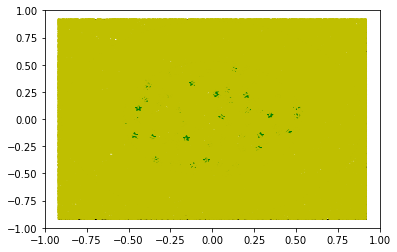

In [32]:
Qualifying2D(100)